# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

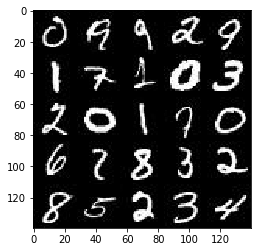

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

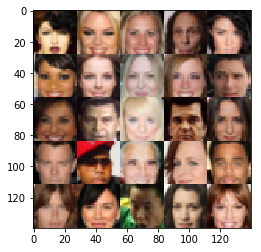

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
alpha=0.15 

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x(1 or 3)
        x1 = tf.layers.conv2d(images, 32, 5, strides=1, padding='same')
        #Not sure why there's no batch norm here (According to previous notebook)
        relu1 = tf.maximum(alpha * x1, x1)
        # 28x28x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x64
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x128

        x4 = tf.layers.conv2d(relu3, 256, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.dropout(x1,0.5) #Based on https://arxiv.org/pdf/1611.07004v1.pdf
        x1 = tf.nn.relu(x1) #Based on original paper
        #x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 7, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.dropout(x2,0.5)
        #x3 = tf.maximum(alpha * x3, x3)
        x2 = tf.nn.relu(x2)
        # 14x14x128 now

        x2 = tf.layers.conv2d_transpose(x2, 64, 7, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.dropout(x2,0.5)
        #x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.relu(x2)
        # 14x14x64 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 7, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.dropout(x3,0.5)
        #x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.relu(x3)
        # 28x28x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 7, strides=1, padding='same')
        # 28x28x(1 or 3) now
        
        out = tf.tanh(logits)
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars) 
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learning_rate_var = model_inputs(data_shape[1], data_shape[2],  data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    losses = []
    print_every = 10
    show_every = 100
    n_images=25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                batch_images=batch_images*2 #go from -0.5 to 0.5 to -1 to 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                x=batch_images
                
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, learning_rate_var:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x, learning_rate_var:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x, learning_rate_var:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                steps+=1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4945... Generator Loss: 1.1774


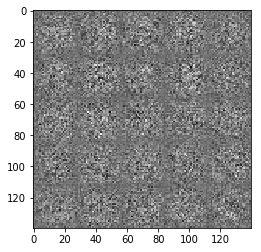

Epoch 1/2... Discriminator Loss: 0.4914... Generator Loss: 1.2558
Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 2.8788
Epoch 1/2... Discriminator Loss: 0.5078... Generator Loss: 1.9036
Epoch 1/2... Discriminator Loss: 0.1396... Generator Loss: 2.6237
Epoch 1/2... Discriminator Loss: 0.3852... Generator Loss: 5.0972
Epoch 1/2... Discriminator Loss: 0.0136... Generator Loss: 7.8529
Epoch 1/2... Discriminator Loss: 0.3651... Generator Loss: 4.1693
Epoch 1/2... Discriminator Loss: 0.0615... Generator Loss: 5.8601
Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 0.9943
Epoch 1/2... Discriminator Loss: 2.8796... Generator Loss: 1.1391


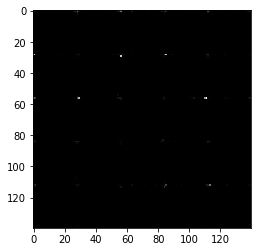

Epoch 1/2... Discriminator Loss: 0.6297... Generator Loss: 1.4789
Epoch 1/2... Discriminator Loss: 0.3814... Generator Loss: 2.5116
Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 2.2505
Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.5018
Epoch 1/2... Discriminator Loss: 0.6382... Generator Loss: 1.2748
Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 2.8820
Epoch 1/2... Discriminator Loss: 0.6443... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 0.6582... Generator Loss: 2.7866
Epoch 1/2... Discriminator Loss: 0.6282... Generator Loss: 1.4229
Epoch 1/2... Discriminator Loss: 0.6455... Generator Loss: 1.2377


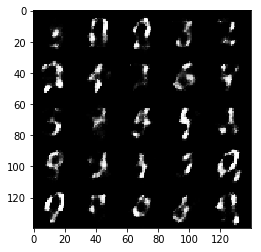

Epoch 1/2... Discriminator Loss: 1.8390... Generator Loss: 0.4140
Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 2.5032
Epoch 1/2... Discriminator Loss: 0.5710... Generator Loss: 1.8687
Epoch 1/2... Discriminator Loss: 0.8137... Generator Loss: 3.0126
Epoch 1/2... Discriminator Loss: 0.6686... Generator Loss: 1.5329
Epoch 1/2... Discriminator Loss: 0.7736... Generator Loss: 1.1548
Epoch 1/2... Discriminator Loss: 0.5428... Generator Loss: 1.7358
Epoch 1/2... Discriminator Loss: 1.0774... Generator Loss: 1.0475
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 2.8090
Epoch 1/2... Discriminator Loss: 0.5885... Generator Loss: 1.9159


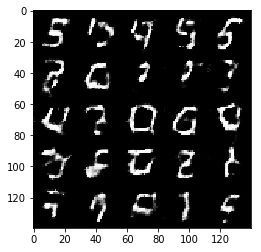

Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 0.7916... Generator Loss: 1.3162
Epoch 1/2... Discriminator Loss: 0.6094... Generator Loss: 1.5772
Epoch 1/2... Discriminator Loss: 0.7596... Generator Loss: 0.8462
Epoch 1/2... Discriminator Loss: 0.8547... Generator Loss: 0.8020
Epoch 1/2... Discriminator Loss: 0.7064... Generator Loss: 0.9862
Epoch 1/2... Discriminator Loss: 0.6880... Generator Loss: 1.5119
Epoch 1/2... Discriminator Loss: 0.8332... Generator Loss: 0.9244
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 0.5638
Epoch 1/2... Discriminator Loss: 0.6829... Generator Loss: 1.2126


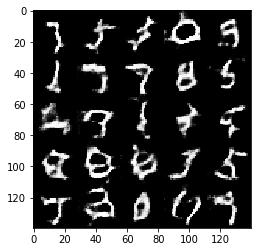

Epoch 1/2... Discriminator Loss: 0.8852... Generator Loss: 2.6141
Epoch 1/2... Discriminator Loss: 0.6942... Generator Loss: 1.3756
Epoch 1/2... Discriminator Loss: 0.5446... Generator Loss: 1.1800
Epoch 1/2... Discriminator Loss: 0.5234... Generator Loss: 1.5798
Epoch 1/2... Discriminator Loss: 0.6817... Generator Loss: 1.1280
Epoch 1/2... Discriminator Loss: 0.5926... Generator Loss: 1.9437
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 1.2739
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 2.7680
Epoch 1/2... Discriminator Loss: 0.5946... Generator Loss: 2.6021
Epoch 1/2... Discriminator Loss: 0.4885... Generator Loss: 2.0542


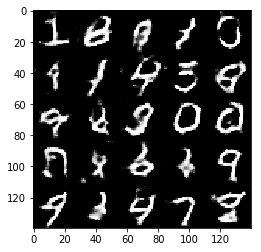

Epoch 1/2... Discriminator Loss: 0.5481... Generator Loss: 2.1417
Epoch 1/2... Discriminator Loss: 0.6817... Generator Loss: 2.0137
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 0.5788
Epoch 1/2... Discriminator Loss: 0.5351... Generator Loss: 2.2030
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 0.5473
Epoch 1/2... Discriminator Loss: 0.6122... Generator Loss: 1.6591
Epoch 1/2... Discriminator Loss: 0.5581... Generator Loss: 1.2717
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 0.5769... Generator Loss: 1.7128


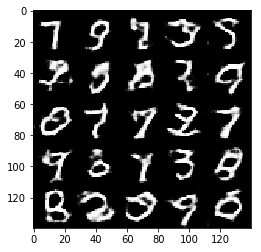

Epoch 1/2... Discriminator Loss: 0.4216... Generator Loss: 2.4192
Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 3.2904
Epoch 1/2... Discriminator Loss: 0.5409... Generator Loss: 1.5634
Epoch 1/2... Discriminator Loss: 0.5508... Generator Loss: 1.3511
Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 1.3192
Epoch 1/2... Discriminator Loss: 0.6294... Generator Loss: 1.6411
Epoch 1/2... Discriminator Loss: 0.6220... Generator Loss: 1.5651
Epoch 1/2... Discriminator Loss: 0.6970... Generator Loss: 1.1873
Epoch 1/2... Discriminator Loss: 0.5499... Generator Loss: 1.6354
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 0.5198


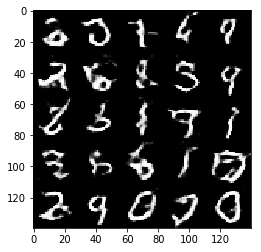

Epoch 1/2... Discriminator Loss: 0.4954... Generator Loss: 2.4560
Epoch 1/2... Discriminator Loss: 0.3149... Generator Loss: 2.2210
Epoch 1/2... Discriminator Loss: 0.8682... Generator Loss: 1.0745
Epoch 1/2... Discriminator Loss: 0.3030... Generator Loss: 2.0349
Epoch 1/2... Discriminator Loss: 0.6199... Generator Loss: 1.3973
Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 1.3328
Epoch 1/2... Discriminator Loss: 0.7311... Generator Loss: 1.4323
Epoch 1/2... Discriminator Loss: 0.4454... Generator Loss: 1.5625
Epoch 1/2... Discriminator Loss: 0.3310... Generator Loss: 2.1160
Epoch 1/2... Discriminator Loss: 0.5119... Generator Loss: 1.5049


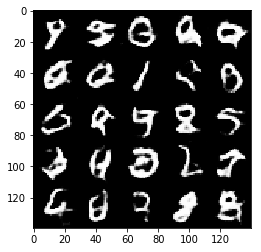

Epoch 1/2... Discriminator Loss: 0.5942... Generator Loss: 0.9373
Epoch 1/2... Discriminator Loss: 0.3292... Generator Loss: 2.3629
Epoch 1/2... Discriminator Loss: 0.3506... Generator Loss: 1.8571
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 0.6939
Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 0.2690... Generator Loss: 2.5142
Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 1.8471
Epoch 1/2... Discriminator Loss: 0.5836... Generator Loss: 3.5996
Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 3.5937
Epoch 1/2... Discriminator Loss: 0.3470... Generator Loss: 1.5921


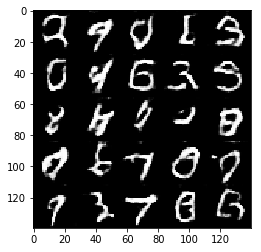

Epoch 1/2... Discriminator Loss: 2.7401... Generator Loss: 5.4091
Epoch 1/2... Discriminator Loss: 0.5580... Generator Loss: 2.2510
Epoch 1/2... Discriminator Loss: 0.4490... Generator Loss: 1.1814
Epoch 1/2... Discriminator Loss: 0.3460... Generator Loss: 2.5093
Epoch 1/2... Discriminator Loss: 0.4155... Generator Loss: 1.5538
Epoch 1/2... Discriminator Loss: 0.5359... Generator Loss: 2.8735
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 0.5874
Epoch 1/2... Discriminator Loss: 0.4485... Generator Loss: 1.7972
Epoch 1/2... Discriminator Loss: 0.6448... Generator Loss: 1.5245
Epoch 1/2... Discriminator Loss: 0.3715... Generator Loss: 2.0598


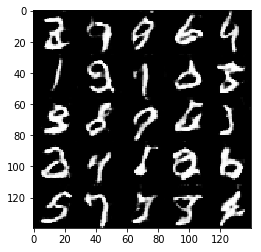

Epoch 1/2... Discriminator Loss: 0.2423... Generator Loss: 2.4104
Epoch 1/2... Discriminator Loss: 0.5958... Generator Loss: 1.4498
Epoch 1/2... Discriminator Loss: 0.2631... Generator Loss: 3.0943
Epoch 1/2... Discriminator Loss: 0.3133... Generator Loss: 1.9692
Epoch 1/2... Discriminator Loss: 0.2027... Generator Loss: 2.8919
Epoch 1/2... Discriminator Loss: 0.2831... Generator Loss: 2.2913
Epoch 1/2... Discriminator Loss: 0.2477... Generator Loss: 1.6533
Epoch 1/2... Discriminator Loss: 6.7692... Generator Loss: 9.0519
Epoch 1/2... Discriminator Loss: 0.7449... Generator Loss: 1.2038
Epoch 1/2... Discriminator Loss: 0.2195... Generator Loss: 3.0164


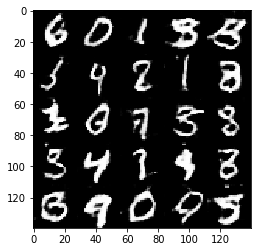

Epoch 1/2... Discriminator Loss: 0.3125... Generator Loss: 2.7639
Epoch 1/2... Discriminator Loss: 0.1826... Generator Loss: 2.6806
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 0.4232... Generator Loss: 1.2479
Epoch 1/2... Discriminator Loss: 0.7789... Generator Loss: 1.5354
Epoch 1/2... Discriminator Loss: 0.3458... Generator Loss: 2.2633
Epoch 1/2... Discriminator Loss: 0.2467... Generator Loss: 3.3202
Epoch 1/2... Discriminator Loss: 0.3495... Generator Loss: 2.2813
Epoch 1/2... Discriminator Loss: 0.2995... Generator Loss: 2.5354
Epoch 1/2... Discriminator Loss: 0.1748... Generator Loss: 2.4325


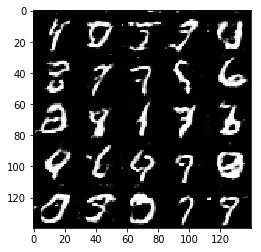

Epoch 1/2... Discriminator Loss: 0.3467... Generator Loss: 3.4589
Epoch 1/2... Discriminator Loss: 0.2633... Generator Loss: 3.2886
Epoch 1/2... Discriminator Loss: 0.1711... Generator Loss: 2.7860
Epoch 1/2... Discriminator Loss: 0.1228... Generator Loss: 3.4730
Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 2.2602
Epoch 1/2... Discriminator Loss: 0.2463... Generator Loss: 3.2875
Epoch 1/2... Discriminator Loss: 0.4165... Generator Loss: 1.8257
Epoch 1/2... Discriminator Loss: 0.1541... Generator Loss: 3.0364
Epoch 1/2... Discriminator Loss: 0.1495... Generator Loss: 2.9251
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.3202


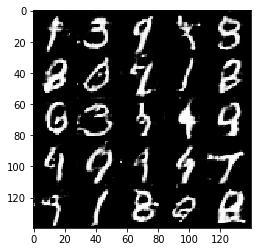

Epoch 1/2... Discriminator Loss: 0.2441... Generator Loss: 2.1630
Epoch 1/2... Discriminator Loss: 0.4473... Generator Loss: 3.5028
Epoch 1/2... Discriminator Loss: 0.2374... Generator Loss: 1.8417
Epoch 1/2... Discriminator Loss: 0.1878... Generator Loss: 2.1983
Epoch 1/2... Discriminator Loss: 0.1531... Generator Loss: 2.6668
Epoch 1/2... Discriminator Loss: 0.7698... Generator Loss: 1.1997
Epoch 1/2... Discriminator Loss: 0.6697... Generator Loss: 2.2135
Epoch 1/2... Discriminator Loss: 0.6205... Generator Loss: 1.4371
Epoch 1/2... Discriminator Loss: 0.5153... Generator Loss: 1.8971
Epoch 1/2... Discriminator Loss: 0.2606... Generator Loss: 3.0544


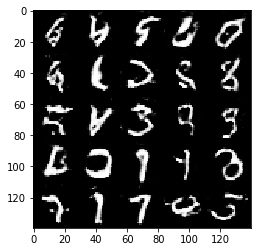

Epoch 1/2... Discriminator Loss: 0.4576... Generator Loss: 2.2032
Epoch 1/2... Discriminator Loss: 0.2566... Generator Loss: 2.5621
Epoch 1/2... Discriminator Loss: 0.5081... Generator Loss: 1.4579
Epoch 1/2... Discriminator Loss: 0.2366... Generator Loss: 2.0519
Epoch 1/2... Discriminator Loss: 0.5979... Generator Loss: 1.0253
Epoch 1/2... Discriminator Loss: 0.3349... Generator Loss: 2.5508
Epoch 1/2... Discriminator Loss: 0.1672... Generator Loss: 2.3928
Epoch 1/2... Discriminator Loss: 0.2345... Generator Loss: 3.0898
Epoch 1/2... Discriminator Loss: 0.6436... Generator Loss: 1.2747
Epoch 1/2... Discriminator Loss: 0.4684... Generator Loss: 2.6508


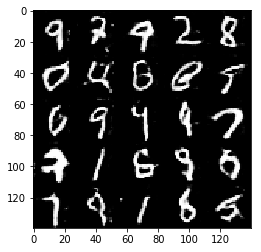

Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 0.4626... Generator Loss: 1.8127
Epoch 1/2... Discriminator Loss: 0.3789... Generator Loss: 2.2210
Epoch 1/2... Discriminator Loss: 0.1982... Generator Loss: 2.2169
Epoch 1/2... Discriminator Loss: 0.3201... Generator Loss: 2.1199
Epoch 1/2... Discriminator Loss: 0.2786... Generator Loss: 2.7868
Epoch 1/2... Discriminator Loss: 0.2285... Generator Loss: 3.3334
Epoch 1/2... Discriminator Loss: 0.1573... Generator Loss: 2.4300
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 0.3500... Generator Loss: 2.0857


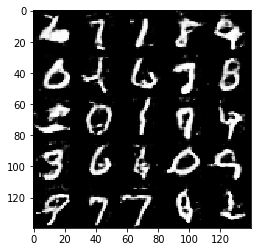

Epoch 1/2... Discriminator Loss: 0.4371... Generator Loss: 2.2586
Epoch 1/2... Discriminator Loss: 0.4373... Generator Loss: 2.3780
Epoch 1/2... Discriminator Loss: 0.3642... Generator Loss: 3.3444
Epoch 1/2... Discriminator Loss: 0.2900... Generator Loss: 2.3809
Epoch 1/2... Discriminator Loss: 0.2855... Generator Loss: 3.4645
Epoch 1/2... Discriminator Loss: 0.1834... Generator Loss: 2.5723
Epoch 1/2... Discriminator Loss: 0.9090... Generator Loss: 0.8619
Epoch 1/2... Discriminator Loss: 0.5800... Generator Loss: 2.4118
Epoch 1/2... Discriminator Loss: 0.2965... Generator Loss: 2.1597
Epoch 1/2... Discriminator Loss: 0.1528... Generator Loss: 3.0485


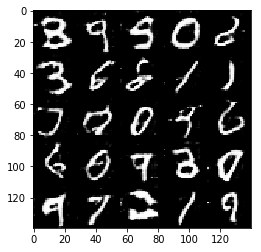

Epoch 1/2... Discriminator Loss: 0.1245... Generator Loss: 2.9314
Epoch 1/2... Discriminator Loss: 0.2460... Generator Loss: 2.1508
Epoch 1/2... Discriminator Loss: 0.1357... Generator Loss: 2.0888
Epoch 1/2... Discriminator Loss: 0.2922... Generator Loss: 1.9333
Epoch 1/2... Discriminator Loss: 0.1761... Generator Loss: 2.7640
Epoch 1/2... Discriminator Loss: 0.1992... Generator Loss: 2.4361
Epoch 1/2... Discriminator Loss: 0.1969... Generator Loss: 2.3789
Epoch 1/2... Discriminator Loss: 0.1256... Generator Loss: 4.2870
Epoch 1/2... Discriminator Loss: 0.2709... Generator Loss: 2.3578
Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 1.7602


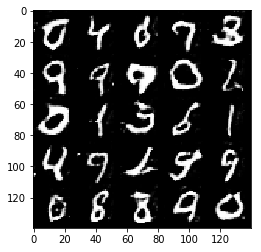

Epoch 1/2... Discriminator Loss: 0.2373... Generator Loss: 2.2542
Epoch 1/2... Discriminator Loss: 0.2892... Generator Loss: 3.3329
Epoch 1/2... Discriminator Loss: 0.1957... Generator Loss: 3.1355
Epoch 1/2... Discriminator Loss: 0.1187... Generator Loss: 3.0626
Epoch 1/2... Discriminator Loss: 0.3293... Generator Loss: 2.6039
Epoch 1/2... Discriminator Loss: 0.2656... Generator Loss: 2.0637
Epoch 1/2... Discriminator Loss: 0.1795... Generator Loss: 2.4523
Epoch 2/2... Discriminator Loss: 2.1614... Generator Loss: 0.3429


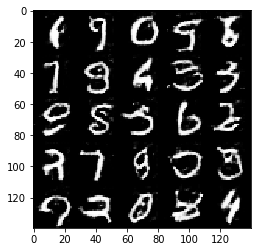

Epoch 2/2... Discriminator Loss: 1.7202... Generator Loss: 0.3268
Epoch 2/2... Discriminator Loss: 0.4782... Generator Loss: 1.8154
Epoch 2/2... Discriminator Loss: 0.3103... Generator Loss: 1.5706
Epoch 2/2... Discriminator Loss: 0.2478... Generator Loss: 2.1979
Epoch 2/2... Discriminator Loss: 0.1553... Generator Loss: 3.7658
Epoch 2/2... Discriminator Loss: 0.1481... Generator Loss: 3.2212
Epoch 2/2... Discriminator Loss: 0.0663... Generator Loss: 4.7924
Epoch 2/2... Discriminator Loss: 0.5405... Generator Loss: 1.0275
Epoch 2/2... Discriminator Loss: 0.1387... Generator Loss: 3.1892
Epoch 2/2... Discriminator Loss: 0.1138... Generator Loss: 2.9814


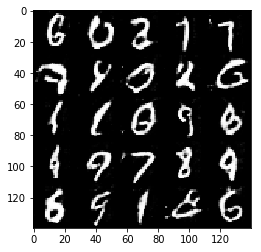

Epoch 2/2... Discriminator Loss: 0.6094... Generator Loss: 3.9962
Epoch 2/2... Discriminator Loss: 0.1918... Generator Loss: 3.0971
Epoch 2/2... Discriminator Loss: 0.2315... Generator Loss: 3.5530
Epoch 2/2... Discriminator Loss: 0.2175... Generator Loss: 1.2993
Epoch 2/2... Discriminator Loss: 0.2245... Generator Loss: 3.1849
Epoch 2/2... Discriminator Loss: 0.1381... Generator Loss: 2.7449
Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 3.8336
Epoch 2/2... Discriminator Loss: 0.5348... Generator Loss: 1.7293
Epoch 2/2... Discriminator Loss: 0.4066... Generator Loss: 2.6115
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.1050


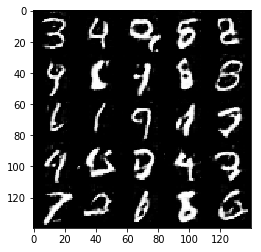

Epoch 2/2... Discriminator Loss: 0.3353... Generator Loss: 2.1611
Epoch 2/2... Discriminator Loss: 0.1824... Generator Loss: 2.8696
Epoch 2/2... Discriminator Loss: 0.2545... Generator Loss: 2.8359
Epoch 2/2... Discriminator Loss: 0.0854... Generator Loss: 3.7895
Epoch 2/2... Discriminator Loss: 2.8870... Generator Loss: 0.1786
Epoch 2/2... Discriminator Loss: 0.3324... Generator Loss: 2.1672
Epoch 2/2... Discriminator Loss: 0.2827... Generator Loss: 2.0526
Epoch 2/2... Discriminator Loss: 0.3139... Generator Loss: 1.3392
Epoch 2/2... Discriminator Loss: 0.1837... Generator Loss: 3.0061
Epoch 2/2... Discriminator Loss: 0.2369... Generator Loss: 2.5589


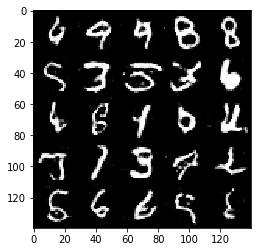

Epoch 2/2... Discriminator Loss: 0.1285... Generator Loss: 3.3865
Epoch 2/2... Discriminator Loss: 0.2119... Generator Loss: 2.6274
Epoch 2/2... Discriminator Loss: 0.1773... Generator Loss: 2.3711
Epoch 2/2... Discriminator Loss: 0.1573... Generator Loss: 2.2640
Epoch 2/2... Discriminator Loss: 0.1399... Generator Loss: 3.6115
Epoch 2/2... Discriminator Loss: 0.2518... Generator Loss: 4.2612
Epoch 2/2... Discriminator Loss: 0.2685... Generator Loss: 2.2102
Epoch 2/2... Discriminator Loss: 0.2822... Generator Loss: 2.4857
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 0.9247
Epoch 2/2... Discriminator Loss: 0.1767... Generator Loss: 4.1250


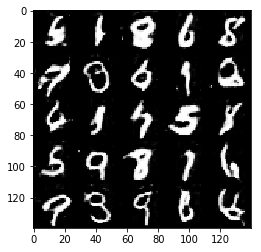

Epoch 2/2... Discriminator Loss: 0.2977... Generator Loss: 3.7704
Epoch 2/2... Discriminator Loss: 0.3340... Generator Loss: 1.9030
Epoch 2/2... Discriminator Loss: 0.2001... Generator Loss: 4.2509
Epoch 2/2... Discriminator Loss: 0.1361... Generator Loss: 3.2046
Epoch 2/2... Discriminator Loss: 0.1004... Generator Loss: 1.9131
Epoch 2/2... Discriminator Loss: 0.1199... Generator Loss: 3.2233
Epoch 2/2... Discriminator Loss: 0.1092... Generator Loss: 3.3797
Epoch 2/2... Discriminator Loss: 0.1959... Generator Loss: 2.6460
Epoch 2/2... Discriminator Loss: 0.1227... Generator Loss: 3.5922
Epoch 2/2... Discriminator Loss: 0.1752... Generator Loss: 2.5824


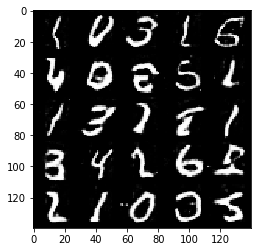

Epoch 2/2... Discriminator Loss: 0.1619... Generator Loss: 3.4007
Epoch 2/2... Discriminator Loss: 0.2714... Generator Loss: 1.3500
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.3260
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 2.7619
Epoch 2/2... Discriminator Loss: 0.2852... Generator Loss: 2.4867
Epoch 2/2... Discriminator Loss: 0.2800... Generator Loss: 1.8411
Epoch 2/2... Discriminator Loss: 0.2257... Generator Loss: 3.0519
Epoch 2/2... Discriminator Loss: 0.1232... Generator Loss: 2.5141
Epoch 2/2... Discriminator Loss: 0.2413... Generator Loss: 3.1408
Epoch 2/2... Discriminator Loss: 0.1468... Generator Loss: 2.0966


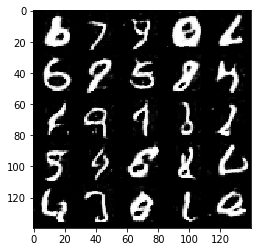

Epoch 2/2... Discriminator Loss: 0.5717... Generator Loss: 2.0073
Epoch 2/2... Discriminator Loss: 0.2517... Generator Loss: 2.8016
Epoch 2/2... Discriminator Loss: 0.1978... Generator Loss: 2.8017
Epoch 2/2... Discriminator Loss: 0.1562... Generator Loss: 1.8233
Epoch 2/2... Discriminator Loss: 0.6354... Generator Loss: 1.0763
Epoch 2/2... Discriminator Loss: 0.1633... Generator Loss: 3.3902
Epoch 2/2... Discriminator Loss: 0.1245... Generator Loss: 2.0741
Epoch 2/2... Discriminator Loss: 0.7608... Generator Loss: 2.1410
Epoch 2/2... Discriminator Loss: 0.3529... Generator Loss: 2.1552
Epoch 2/2... Discriminator Loss: 0.2060... Generator Loss: 2.4003


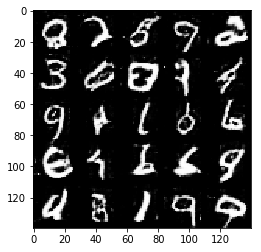

Epoch 2/2... Discriminator Loss: 0.1920... Generator Loss: 3.2285
Epoch 2/2... Discriminator Loss: 0.0823... Generator Loss: 4.8811
Epoch 2/2... Discriminator Loss: 0.2377... Generator Loss: 2.3747
Epoch 2/2... Discriminator Loss: 0.1495... Generator Loss: 2.6815
Epoch 2/2... Discriminator Loss: 0.4458... Generator Loss: 3.9731
Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 3.3336
Epoch 2/2... Discriminator Loss: 0.1820... Generator Loss: 2.7887
Epoch 2/2... Discriminator Loss: 0.2043... Generator Loss: 3.4198
Epoch 2/2... Discriminator Loss: 0.0735... Generator Loss: 3.7767
Epoch 2/2... Discriminator Loss: 0.1240... Generator Loss: 4.5157


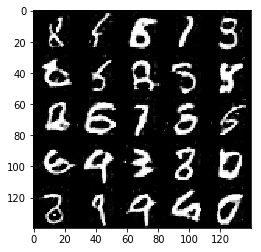

Epoch 2/2... Discriminator Loss: 0.2315... Generator Loss: 2.6473
Epoch 2/2... Discriminator Loss: 0.0816... Generator Loss: 2.6765
Epoch 2/2... Discriminator Loss: 0.2872... Generator Loss: 2.9170
Epoch 2/2... Discriminator Loss: 0.1335... Generator Loss: 4.8502
Epoch 2/2... Discriminator Loss: 0.1110... Generator Loss: 3.5027
Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 1.8169
Epoch 2/2... Discriminator Loss: 0.1305... Generator Loss: 2.0874
Epoch 2/2... Discriminator Loss: 0.0666... Generator Loss: 3.8217
Epoch 2/2... Discriminator Loss: 0.1063... Generator Loss: 3.8742
Epoch 2/2... Discriminator Loss: 0.0563... Generator Loss: 3.7852


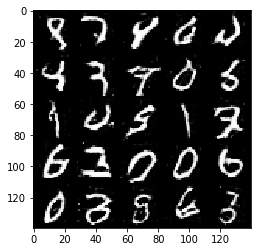

Epoch 2/2... Discriminator Loss: 0.1890... Generator Loss: 1.8292
Epoch 2/2... Discriminator Loss: 0.2085... Generator Loss: 2.2544
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 0.7755
Epoch 2/2... Discriminator Loss: 0.1934... Generator Loss: 3.0690
Epoch 2/2... Discriminator Loss: 0.1325... Generator Loss: 3.0327
Epoch 2/2... Discriminator Loss: 0.2686... Generator Loss: 1.6227
Epoch 2/2... Discriminator Loss: 0.1807... Generator Loss: 2.3097
Epoch 2/2... Discriminator Loss: 0.1546... Generator Loss: 4.1852
Epoch 2/2... Discriminator Loss: 0.1099... Generator Loss: 2.8549
Epoch 2/2... Discriminator Loss: 0.0601... Generator Loss: 3.2861


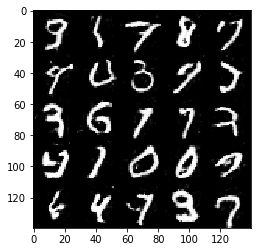

Epoch 2/2... Discriminator Loss: 0.0542... Generator Loss: 6.0988
Epoch 2/2... Discriminator Loss: 1.8751... Generator Loss: 5.9221
Epoch 2/2... Discriminator Loss: 0.1411... Generator Loss: 2.6506
Epoch 2/2... Discriminator Loss: 0.0815... Generator Loss: 5.0102
Epoch 2/2... Discriminator Loss: 0.2228... Generator Loss: 4.2853
Epoch 2/2... Discriminator Loss: 0.4279... Generator Loss: 1.5658
Epoch 2/2... Discriminator Loss: 0.1257... Generator Loss: 3.5459
Epoch 2/2... Discriminator Loss: 0.1194... Generator Loss: 2.6766
Epoch 2/2... Discriminator Loss: 0.1859... Generator Loss: 3.5236
Epoch 2/2... Discriminator Loss: 0.1152... Generator Loss: 3.4809


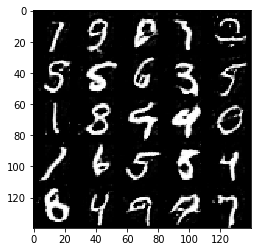

Epoch 2/2... Discriminator Loss: 0.2601... Generator Loss: 3.9122
Epoch 2/2... Discriminator Loss: 0.0904... Generator Loss: 4.3527
Epoch 2/2... Discriminator Loss: 0.1189... Generator Loss: 2.8658
Epoch 2/2... Discriminator Loss: 0.3699... Generator Loss: 2.3966
Epoch 2/2... Discriminator Loss: 0.0829... Generator Loss: 3.4458
Epoch 2/2... Discriminator Loss: 0.2120... Generator Loss: 2.6508
Epoch 2/2... Discriminator Loss: 0.1098... Generator Loss: 3.1762
Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 4.2930
Epoch 2/2... Discriminator Loss: 0.1208... Generator Loss: 2.4889
Epoch 2/2... Discriminator Loss: 0.2344... Generator Loss: 4.3996


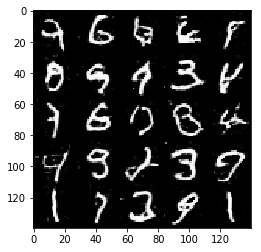

Epoch 2/2... Discriminator Loss: 0.1006... Generator Loss: 3.1870
Epoch 2/2... Discriminator Loss: 0.4126... Generator Loss: 5.6212
Epoch 2/2... Discriminator Loss: 0.0757... Generator Loss: 4.2369
Epoch 2/2... Discriminator Loss: 0.1051... Generator Loss: 3.5226
Epoch 2/2... Discriminator Loss: 0.1271... Generator Loss: 5.1254
Epoch 2/2... Discriminator Loss: 0.0890... Generator Loss: 2.4166
Epoch 2/2... Discriminator Loss: 0.2386... Generator Loss: 2.9545
Epoch 2/2... Discriminator Loss: 0.0709... Generator Loss: 3.3198
Epoch 2/2... Discriminator Loss: 0.0858... Generator Loss: 3.3504
Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 3.5642


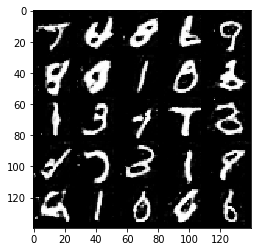

Epoch 2/2... Discriminator Loss: 0.0554... Generator Loss: 3.9517
Epoch 2/2... Discriminator Loss: 0.0673... Generator Loss: 4.0525
Epoch 2/2... Discriminator Loss: 0.2285... Generator Loss: 2.5385
Epoch 2/2... Discriminator Loss: 0.0524... Generator Loss: 3.8339
Epoch 2/2... Discriminator Loss: 0.1458... Generator Loss: 2.3792
Epoch 2/2... Discriminator Loss: 0.1039... Generator Loss: 5.0956
Epoch 2/2... Discriminator Loss: 0.1343... Generator Loss: 2.6354
Epoch 2/2... Discriminator Loss: 0.0701... Generator Loss: 2.4539
Epoch 2/2... Discriminator Loss: 1.6755... Generator Loss: 4.3548
Epoch 2/2... Discriminator Loss: 0.5581... Generator Loss: 3.1446


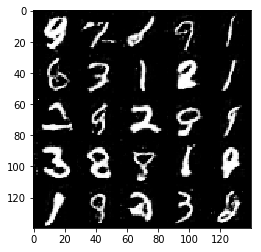

Epoch 2/2... Discriminator Loss: 0.4499... Generator Loss: 1.5479
Epoch 2/2... Discriminator Loss: 0.2338... Generator Loss: 2.1541
Epoch 2/2... Discriminator Loss: 0.2892... Generator Loss: 2.8182
Epoch 2/2... Discriminator Loss: 0.1076... Generator Loss: 2.5818
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 1.3557
Epoch 2/2... Discriminator Loss: 0.3091... Generator Loss: 2.7478
Epoch 2/2... Discriminator Loss: 0.1900... Generator Loss: 3.1184
Epoch 2/2... Discriminator Loss: 0.0697... Generator Loss: 3.1390
Epoch 2/2... Discriminator Loss: 0.1480... Generator Loss: 3.7225
Epoch 2/2... Discriminator Loss: 0.0639... Generator Loss: 3.5330


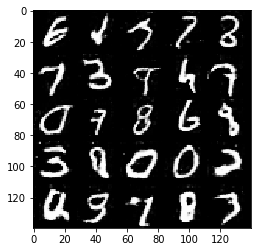

Epoch 2/2... Discriminator Loss: 0.1945... Generator Loss: 3.8265
Epoch 2/2... Discriminator Loss: 0.2275... Generator Loss: 4.3249
Epoch 2/2... Discriminator Loss: 0.1538... Generator Loss: 3.1391
Epoch 2/2... Discriminator Loss: 0.2918... Generator Loss: 1.8932
Epoch 2/2... Discriminator Loss: 0.0686... Generator Loss: 3.4224
Epoch 2/2... Discriminator Loss: 0.0618... Generator Loss: 3.5871
Epoch 2/2... Discriminator Loss: 0.1178... Generator Loss: 2.9640
Epoch 2/2... Discriminator Loss: 0.0942... Generator Loss: 2.8332
Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 4.0272
Epoch 2/2... Discriminator Loss: 0.1221... Generator Loss: 3.3781


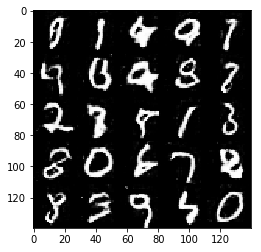

Epoch 2/2... Discriminator Loss: 2.3760... Generator Loss: 5.5693
Epoch 2/2... Discriminator Loss: 0.1612... Generator Loss: 3.7027
Epoch 2/2... Discriminator Loss: 0.1868... Generator Loss: 2.4209
Epoch 2/2... Discriminator Loss: 0.1595... Generator Loss: 3.0411
Epoch 2/2... Discriminator Loss: 0.2969... Generator Loss: 2.4320
Epoch 2/2... Discriminator Loss: 0.0556... Generator Loss: 3.4279
Epoch 2/2... Discriminator Loss: 0.0949... Generator Loss: 2.8051
Epoch 2/2... Discriminator Loss: 0.1829... Generator Loss: 2.2479
Epoch 2/2... Discriminator Loss: 0.0966... Generator Loss: 3.9746
Epoch 2/2... Discriminator Loss: 0.1389... Generator Loss: 3.8594


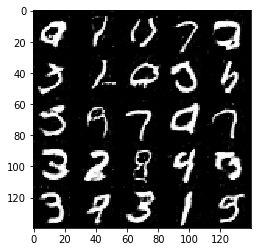

Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.9966
Epoch 2/2... Discriminator Loss: 0.0934... Generator Loss: 2.9462
Epoch 2/2... Discriminator Loss: 0.0842... Generator Loss: 3.2809
Epoch 2/2... Discriminator Loss: 0.0757... Generator Loss: 4.1884
Epoch 2/2... Discriminator Loss: 0.0714... Generator Loss: 3.9197
Epoch 2/2... Discriminator Loss: 0.0402... Generator Loss: 4.5173
Epoch 2/2... Discriminator Loss: 0.7759... Generator Loss: 6.3724
Epoch 2/2... Discriminator Loss: 0.1380... Generator Loss: 3.4162
Epoch 2/2... Discriminator Loss: 0.1003... Generator Loss: 2.6879
Epoch 2/2... Discriminator Loss: 0.1062... Generator Loss: 2.3201


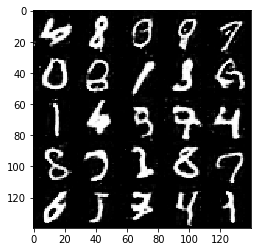

Epoch 2/2... Discriminator Loss: 0.1816... Generator Loss: 4.8224
Epoch 2/2... Discriminator Loss: 0.2433... Generator Loss: 3.5218
Epoch 2/2... Discriminator Loss: 0.1687... Generator Loss: 2.3983
Epoch 2/2... Discriminator Loss: 0.0373... Generator Loss: 3.8959
Epoch 2/2... Discriminator Loss: 0.1581... Generator Loss: 3.1138
Epoch 2/2... Discriminator Loss: 0.1307... Generator Loss: 3.0294
Epoch 2/2... Discriminator Loss: 0.0744... Generator Loss: 3.1426


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 0.8704


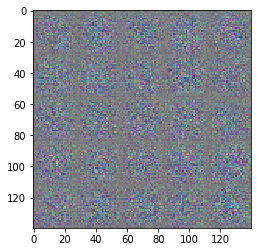

Epoch 1/1... Discriminator Loss: 0.1483... Generator Loss: 2.4574
Epoch 1/1... Discriminator Loss: 0.0574... Generator Loss: 3.8648
Epoch 1/1... Discriminator Loss: 0.0337... Generator Loss: 3.7543
Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 3.0089
Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 4.5090
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 4.9114
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 5.2909
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 5.4251
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 2.4565
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 6.5890


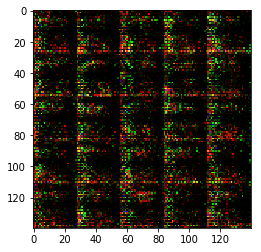

Epoch 1/1... Discriminator Loss: 0.0650... Generator Loss: 3.1954
Epoch 1/1... Discriminator Loss: 0.0676... Generator Loss: 3.4564
Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 3.4128
Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 6.2631
Epoch 1/1... Discriminator Loss: 0.1512... Generator Loss: 3.4998
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 2.2461
Epoch 1/1... Discriminator Loss: 0.2247... Generator Loss: 3.5771
Epoch 1/1... Discriminator Loss: 0.0981... Generator Loss: 11.5802
Epoch 1/1... Discriminator Loss: 0.1453... Generator Loss: 5.6014
Epoch 1/1... Discriminator Loss: 0.0818... Generator Loss: 3.2673


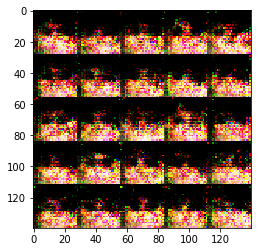

Epoch 1/1... Discriminator Loss: 0.0465... Generator Loss: 4.0445
Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 3.4539
Epoch 1/1... Discriminator Loss: 0.0383... Generator Loss: 4.6492
Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 4.0645
Epoch 1/1... Discriminator Loss: 0.1474... Generator Loss: 6.1518
Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 3.6525
Epoch 1/1... Discriminator Loss: 0.0822... Generator Loss: 4.0293
Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 4.1494
Epoch 1/1... Discriminator Loss: 0.0385... Generator Loss: 4.7157
Epoch 1/1... Discriminator Loss: 0.0411... Generator Loss: 4.3227


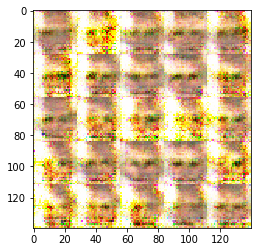

Epoch 1/1... Discriminator Loss: 0.0690... Generator Loss: 4.1180
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 4.3969
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 3.8765
Epoch 1/1... Discriminator Loss: 0.0868... Generator Loss: 2.9829
Epoch 1/1... Discriminator Loss: 0.2491... Generator Loss: 2.2277
Epoch 1/1... Discriminator Loss: 0.1936... Generator Loss: 5.3789
Epoch 1/1... Discriminator Loss: 0.1085... Generator Loss: 3.2832
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 4.2157
Epoch 1/1... Discriminator Loss: 0.1039... Generator Loss: 3.3115
Epoch 1/1... Discriminator Loss: 0.0913... Generator Loss: 3.5921


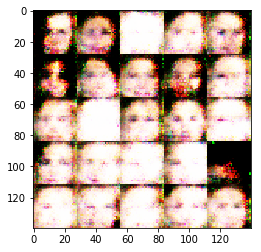

Epoch 1/1... Discriminator Loss: 0.1183... Generator Loss: 3.5479
Epoch 1/1... Discriminator Loss: 0.0861... Generator Loss: 4.4250
Epoch 1/1... Discriminator Loss: 0.1261... Generator Loss: 2.2618
Epoch 1/1... Discriminator Loss: 0.1742... Generator Loss: 2.5890
Epoch 1/1... Discriminator Loss: 0.0392... Generator Loss: 4.0557
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 1.7302
Epoch 1/1... Discriminator Loss: 0.0846... Generator Loss: 3.6195
Epoch 1/1... Discriminator Loss: 0.0651... Generator Loss: 3.4096
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 0.2451... Generator Loss: 3.8775


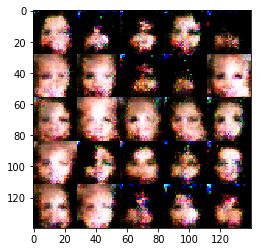

Epoch 1/1... Discriminator Loss: 0.1388... Generator Loss: 3.5764
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 2.0943
Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 2.0558
Epoch 1/1... Discriminator Loss: 0.2628... Generator Loss: 3.1688
Epoch 1/1... Discriminator Loss: 0.3308... Generator Loss: 1.7375
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 3.1212
Epoch 1/1... Discriminator Loss: 0.3024... Generator Loss: 4.2180
Epoch 1/1... Discriminator Loss: 0.0801... Generator Loss: 5.3258
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 3.5595
Epoch 1/1... Discriminator Loss: 0.1371... Generator Loss: 2.9220


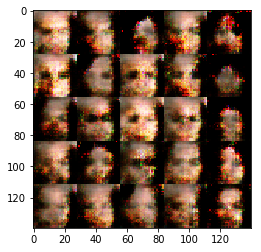

Epoch 1/1... Discriminator Loss: 0.0861... Generator Loss: 3.9570
Epoch 1/1... Discriminator Loss: 0.1102... Generator Loss: 4.0867
Epoch 1/1... Discriminator Loss: 0.1663... Generator Loss: 2.2076
Epoch 1/1... Discriminator Loss: 0.2244... Generator Loss: 3.5080
Epoch 1/1... Discriminator Loss: 0.1295... Generator Loss: 4.9206
Epoch 1/1... Discriminator Loss: 0.2876... Generator Loss: 2.8428
Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 3.9250
Epoch 1/1... Discriminator Loss: 0.3301... Generator Loss: 2.0876
Epoch 1/1... Discriminator Loss: 0.2453... Generator Loss: 3.4083
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.5998


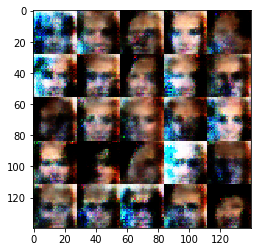

Epoch 1/1... Discriminator Loss: 0.0810... Generator Loss: 4.2464
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 3.7210
Epoch 1/1... Discriminator Loss: 0.2620... Generator Loss: 2.3614
Epoch 1/1... Discriminator Loss: 0.2997... Generator Loss: 2.2470
Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 2.0179
Epoch 1/1... Discriminator Loss: 0.2678... Generator Loss: 2.2489
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 3.9324
Epoch 1/1... Discriminator Loss: 0.2668... Generator Loss: 4.0713
Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 1.8706
Epoch 1/1... Discriminator Loss: 0.2302... Generator Loss: 2.7247


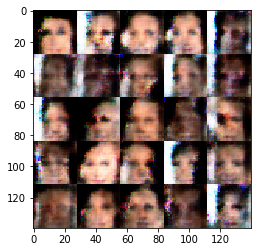

Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 2.5379
Epoch 1/1... Discriminator Loss: 0.3384... Generator Loss: 2.4940
Epoch 1/1... Discriminator Loss: 0.1941... Generator Loss: 3.3947
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 0.2212... Generator Loss: 3.3069
Epoch 1/1... Discriminator Loss: 0.3013... Generator Loss: 3.3685
Epoch 1/1... Discriminator Loss: 0.3134... Generator Loss: 3.2031
Epoch 1/1... Discriminator Loss: 0.2510... Generator Loss: 3.9224
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 7.5840
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8000


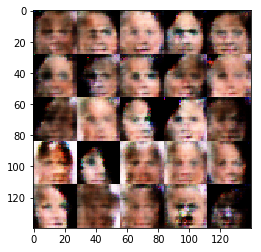

Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 2.1558
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 1.5827
Epoch 1/1... Discriminator Loss: 0.2445... Generator Loss: 2.9347
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 4.1257
Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 0.2518... Generator Loss: 3.8700
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 3.1536
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 1.3661
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 2.8943
Epoch 1/1... Discriminator Loss: 0.2569... Generator Loss: 2.6018


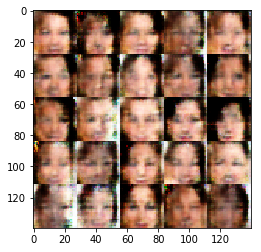

Epoch 1/1... Discriminator Loss: 0.3182... Generator Loss: 2.4476
Epoch 1/1... Discriminator Loss: 0.2511... Generator Loss: 3.2770
Epoch 1/1... Discriminator Loss: 0.4288... Generator Loss: 3.2759
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 5.0938
Epoch 1/1... Discriminator Loss: 0.2257... Generator Loss: 3.0530
Epoch 1/1... Discriminator Loss: 0.2922... Generator Loss: 3.3203
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 2.1514
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 2.9509
Epoch 1/1... Discriminator Loss: 0.1796... Generator Loss: 3.9178
Epoch 1/1... Discriminator Loss: 0.1040... Generator Loss: 3.8491


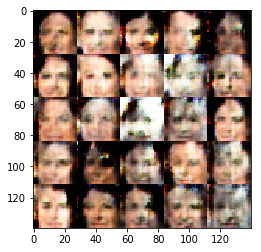

Epoch 1/1... Discriminator Loss: 0.2042... Generator Loss: 1.8052
Epoch 1/1... Discriminator Loss: 0.2998... Generator Loss: 3.1559
Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 2.0512
Epoch 1/1... Discriminator Loss: 0.3313... Generator Loss: 2.5928
Epoch 1/1... Discriminator Loss: 0.3206... Generator Loss: 2.0862
Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 3.9273
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.6928
Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 2.4509
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 2.6467
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 2.0333


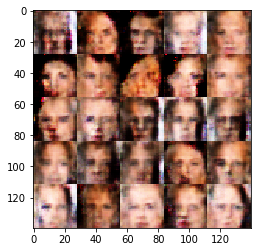

Epoch 1/1... Discriminator Loss: 0.2462... Generator Loss: 2.9919
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 3.3294
Epoch 1/1... Discriminator Loss: 0.3222... Generator Loss: 1.9551
Epoch 1/1... Discriminator Loss: 0.3098... Generator Loss: 2.2747
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 1.9697
Epoch 1/1... Discriminator Loss: 0.2927... Generator Loss: 2.5792
Epoch 1/1... Discriminator Loss: 0.2457... Generator Loss: 2.8385
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 2.6359
Epoch 1/1... Discriminator Loss: 0.2434... Generator Loss: 3.0128
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 2.3159


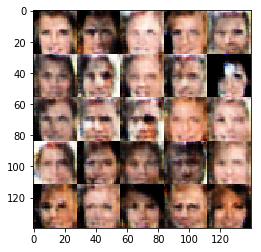

Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 1.7393
Epoch 1/1... Discriminator Loss: 0.2043... Generator Loss: 2.9440
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 2.2673
Epoch 1/1... Discriminator Loss: 0.1439... Generator Loss: 3.6438
Epoch 1/1... Discriminator Loss: 0.2839... Generator Loss: 3.4508
Epoch 1/1... Discriminator Loss: 0.4652... Generator Loss: 2.6234
Epoch 1/1... Discriminator Loss: 0.2892... Generator Loss: 2.4969
Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 3.1306
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 3.4670
Epoch 1/1... Discriminator Loss: 0.2404... Generator Loss: 3.4186


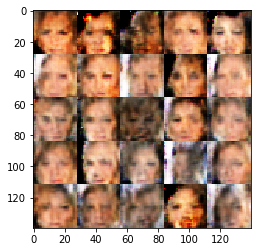

Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 2.1938
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 1.8225
Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 4.5929
Epoch 1/1... Discriminator Loss: 0.3147... Generator Loss: 3.6921
Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 4.1267
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 2.4467
Epoch 1/1... Discriminator Loss: 0.1998... Generator Loss: 2.8044
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 1.9689
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 1.7050
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 2.7863


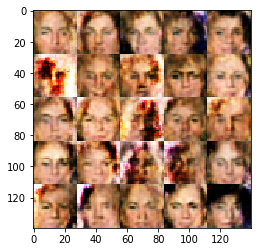

Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 3.4369
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 2.8573
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 1.1606
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.2348
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 1.8373
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 1.3473
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 2.0311
Epoch 1/1... Discriminator Loss: 0.3420... Generator Loss: 3.7698
Epoch 1/1... Discriminator Loss: 0.3205... Generator Loss: 2.8387


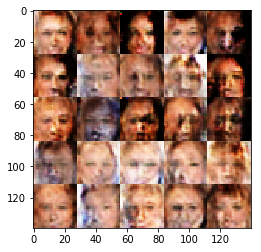

Epoch 1/1... Discriminator Loss: 0.2217... Generator Loss: 3.1558
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 1.8512
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 1.9853
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 3.4271
Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 1.9532
Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 1.8304
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 1.2546
Epoch 1/1... Discriminator Loss: 0.3042... Generator Loss: 2.4899
Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 1.6062


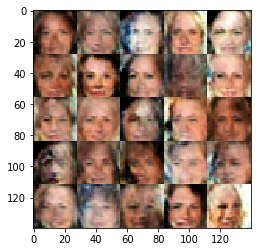

Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 2.3883
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 0.3039... Generator Loss: 2.4424
Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 1.6100
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 3.2693
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 3.1070
Epoch 1/1... Discriminator Loss: 0.2831... Generator Loss: 3.1644
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 2.5928
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 2.5484
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 2.4247


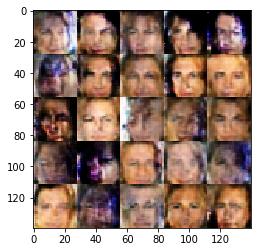

Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 1.3414
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 3.0898
Epoch 1/1... Discriminator Loss: 0.2982... Generator Loss: 2.5609
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 2.4857
Epoch 1/1... Discriminator Loss: 0.3030... Generator Loss: 2.2615
Epoch 1/1... Discriminator Loss: 0.3310... Generator Loss: 2.5634
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 2.1230
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 0.3213... Generator Loss: 2.6963


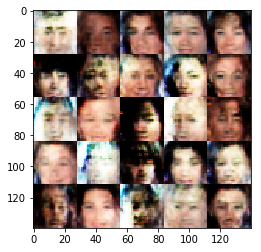

Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 3.0447
Epoch 1/1... Discriminator Loss: 0.2215... Generator Loss: 3.5415
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.6412
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 3.9416
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 1.8479
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 1.9275
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 3.1820
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.4165
Epoch 1/1... Discriminator Loss: 0.3772... Generator Loss: 1.7023


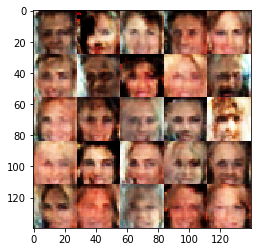

Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 2.1302
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.6214
Epoch 1/1... Discriminator Loss: 0.3174... Generator Loss: 1.6951
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 2.9786
Epoch 1/1... Discriminator Loss: 0.3281... Generator Loss: 2.2070
Epoch 1/1... Discriminator Loss: 0.4131... Generator Loss: 2.3659
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 0.2967... Generator Loss: 2.5331
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 2.3215
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 2.2605


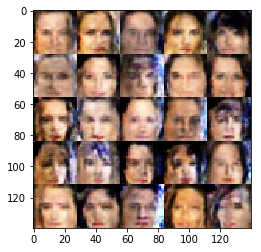

Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 1.6941
Epoch 1/1... Discriminator Loss: 0.4132... Generator Loss: 2.2275
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 2.2365
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 2.4709
Epoch 1/1... Discriminator Loss: 0.3098... Generator Loss: 3.0639
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 1.7553
Epoch 1/1... Discriminator Loss: 0.3266... Generator Loss: 1.7675
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 2.7781
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 1.1462
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 1.6303


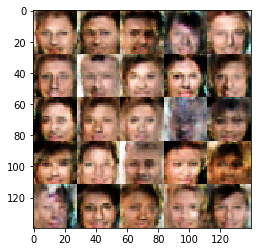

Epoch 1/1... Discriminator Loss: 0.2726... Generator Loss: 2.0506
Epoch 1/1... Discriminator Loss: 0.2662... Generator Loss: 2.1613
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 1.7130
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 2.6347
Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 0.3105... Generator Loss: 3.2715
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 1.6510
Epoch 1/1... Discriminator Loss: 0.3146... Generator Loss: 2.0466
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 2.7080


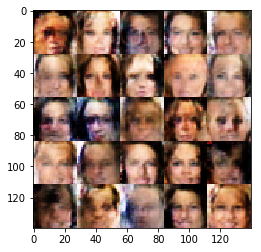

Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 1.8394
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 2.1952
Epoch 1/1... Discriminator Loss: 0.6471... Generator Loss: 1.8516
Epoch 1/1... Discriminator Loss: 0.3295... Generator Loss: 3.8870
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 1.9152
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 1.5403
Epoch 1/1... Discriminator Loss: 0.4556... Generator Loss: 2.8898
Epoch 1/1... Discriminator Loss: 0.2669... Generator Loss: 2.8406
Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 2.4485


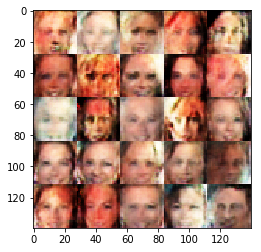

Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 2.4118
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 1.9918
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 0.2188... Generator Loss: 2.7125
Epoch 1/1... Discriminator Loss: 0.2735... Generator Loss: 1.9897
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.3601
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 3.3889
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 0.6488... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 1.6071


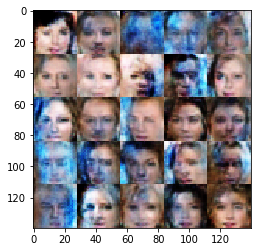

Epoch 1/1... Discriminator Loss: 0.3728... Generator Loss: 2.0616
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.7254
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 2.4342
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 2.0698
Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 2.5389
Epoch 1/1... Discriminator Loss: 0.5506... Generator Loss: 2.1135
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.7875
Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 2.1050
Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 2.2710
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 2.0340


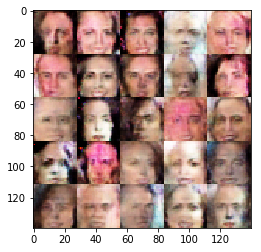

Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 2.0994
Epoch 1/1... Discriminator Loss: 0.4922... Generator Loss: 2.2172
Epoch 1/1... Discriminator Loss: 0.6738... Generator Loss: 3.4687
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 1.7388
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 2.0515
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 2.1184
Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 1.9116
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 2.0189
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 1.8400


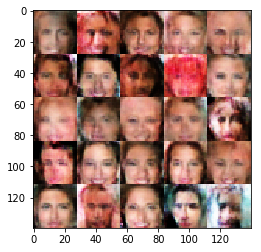

Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 1.4467
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 2.4641
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 2.4537
Epoch 1/1... Discriminator Loss: 0.3153... Generator Loss: 2.7357
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 1.5548
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 2.2156
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 1.9659
Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 2.5102
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 1.7429
Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 2.2455


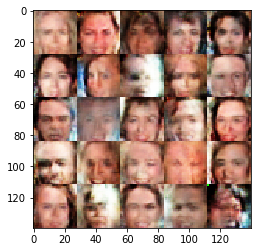

Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 2.3122
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 2.8431
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 1.8318
Epoch 1/1... Discriminator Loss: 0.2746... Generator Loss: 2.7200
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 2.5738
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 1.8745
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 1.3766
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 1.9279


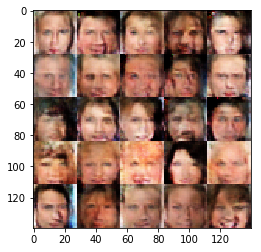

Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 1.6157
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 2.4408
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 1.9585
Epoch 1/1... Discriminator Loss: 0.5438... Generator Loss: 1.8034
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 2.2017
Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 1.5005
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.7556
Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 1.8630
Epoch 1/1... Discriminator Loss: 0.2707... Generator Loss: 2.9163
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 1.7227


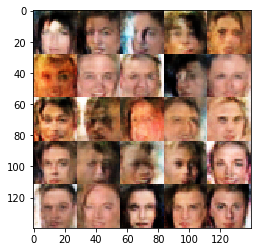

Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 2.5511
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 2.0814
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 1.4051
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 1.6926
Epoch 1/1... Discriminator Loss: 0.4262... Generator Loss: 2.0340
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 1.5897
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 2.4554
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 1.7070
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 1.3104


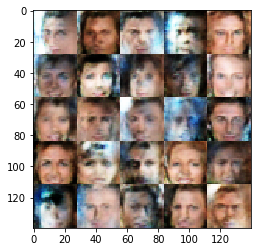

Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 2.3316
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 2.0753
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 1.7790
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 2.3001
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 2.0131
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 2.2858
Epoch 1/1... Discriminator Loss: 0.5773... Generator Loss: 1.7280
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 2.1978


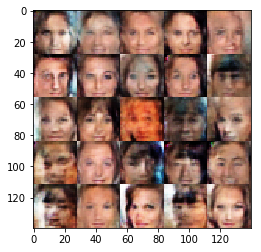

Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 2.0945
Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 2.1952
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 2.4908
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 1.6042
Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 2.1172
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 3.1706
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.6214
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 1.5941
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 1.7937
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 2.2743


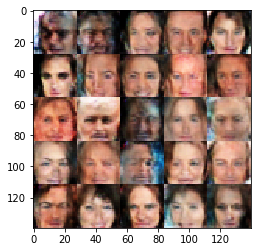

Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 1.5116
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 2.6072
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 1.8904
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 1.5186
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 2.6700
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 0.3719... Generator Loss: 2.6246
Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 1.5484


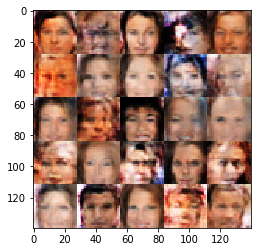

Epoch 1/1... Discriminator Loss: 0.2993... Generator Loss: 2.5017
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 1.8714
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 2.2464
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 1.6795
Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 2.1470
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 2.8449
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 2.8204
Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 1.4979
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 2.3358
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 2.8593


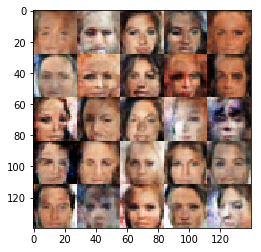

Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.9157
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 2.1033
Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 1.9164
Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 1.8689
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 2.2491
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.7012
Epoch 1/1... Discriminator Loss: 0.2949... Generator Loss: 2.8770
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 1.9271
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 2.2521


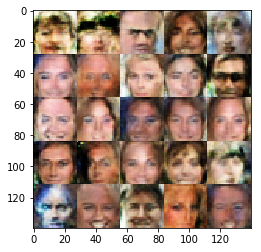

Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 1.8664
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.7299
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 1.4552
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 1.5870
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 1.8548
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 2.3391
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 1.1939
Epoch 1/1... Discriminator Loss: 0.5662... Generator Loss: 1.1579


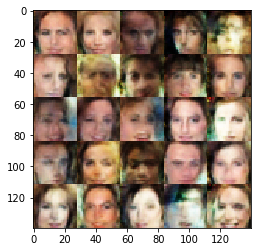

Epoch 1/1... Discriminator Loss: 0.2657... Generator Loss: 2.7900
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.8790
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 2.0509
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 1.5143
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 2.4194
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 2.1398
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 1.8617
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 1.3319
Epoch 1/1... Discriminator Loss: 0.2664... Generator Loss: 2.6801


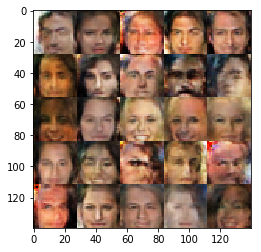

Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 2.2196
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.3274
Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 1.6787
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 1.6789
Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 2.4090
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 1.4783
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 1.6242
Epoch 1/1... Discriminator Loss: 0.3631... Generator Loss: 2.8035
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 1.7254
Epoch 1/1... Discriminator Loss: 0.6178... Generator Loss: 1.1248


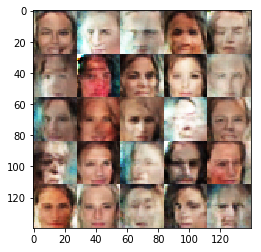

Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 2.7362
Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 1.3391
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 1.6282
Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 2.0960
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 1.9842
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 2.3931
Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 2.5287


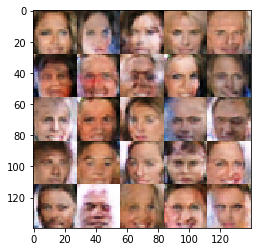

Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 2.8145
Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 2.2966
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 2.1329
Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 1.5106
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 2.7456
Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 1.9571
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 1.9128


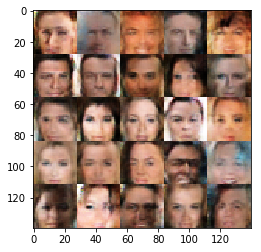

Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 2.0270
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 1.6895
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 0.2610... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 1.4824
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 2.0762
Epoch 1/1... Discriminator Loss: 0.5011... Generator Loss: 2.5241
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 2.3313


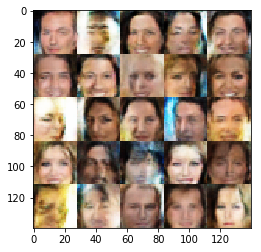

Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 1.5730
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 1.8046
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 2.7530
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 1.9796
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 1.9606
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.7427
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 1.7833
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 1.9385


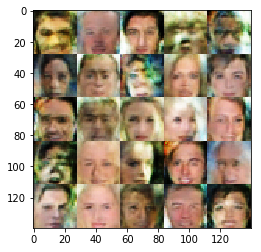

Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 2.2853
Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 2.2583
Epoch 1/1... Discriminator Loss: 0.4737... Generator Loss: 1.8638
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 1.9867
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 2.1707
Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 2.6308
Epoch 1/1... Discriminator Loss: 0.5856... Generator Loss: 2.3145
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 1.7817
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 1.9110


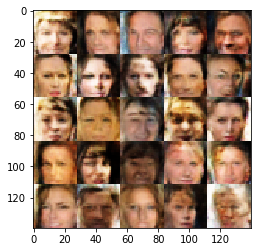

Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 2.3589
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 1.2747
Epoch 1/1... Discriminator Loss: 0.6455... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 1.9829
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 1.7968
Epoch 1/1... Discriminator Loss: 0.4847... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.2407
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 2.6237


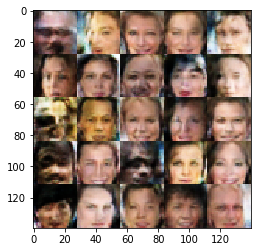

Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 1.8416
Epoch 1/1... Discriminator Loss: 0.4542... Generator Loss: 2.0000
Epoch 1/1... Discriminator Loss: 0.4694... Generator Loss: 1.9536
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 2.2148
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 1.7633
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 1.8028
Epoch 1/1... Discriminator Loss: 0.4999... Generator Loss: 1.6390
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 1.9383
Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 4.5430


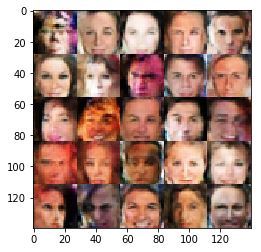

Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 1.6971
Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 1.5736
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 1.5622
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 2.2031
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 1.7911
Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 1.6772
Epoch 1/1... Discriminator Loss: 0.2931... Generator Loss: 2.2035
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 1.9622


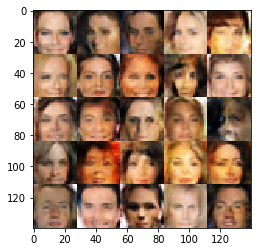

Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 2.1176
Epoch 1/1... Discriminator Loss: 0.4306... Generator Loss: 1.5709
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 1.6232
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 0.4437... Generator Loss: 2.2069
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 2.5880
Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 2.2733
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 2.3524
Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 1.8489
Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 2.0330


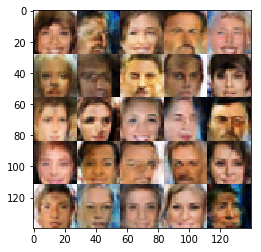

Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 2.3510
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 1.4511
Epoch 1/1... Discriminator Loss: 0.3755... Generator Loss: 1.6763
Epoch 1/1... Discriminator Loss: 0.6472... Generator Loss: 1.3848
Epoch 1/1... Discriminator Loss: 0.4449... Generator Loss: 1.7188
Epoch 1/1... Discriminator Loss: 0.3349... Generator Loss: 1.7775
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 2.0536
Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 1.6144
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 2.1263
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 1.5527


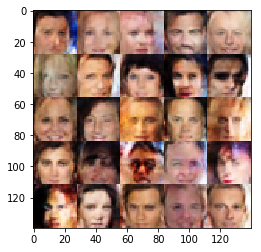

Epoch 1/1... Discriminator Loss: 0.4515... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.4873
Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 2.0269
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 2.7410
Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 1.6614
Epoch 1/1... Discriminator Loss: 0.5003... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 1.9022
Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 1.7570
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 1.6881
Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 1.8313


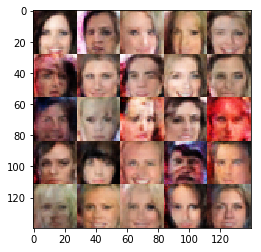

Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 2.2757
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.1449
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 1.9583
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 2.4616


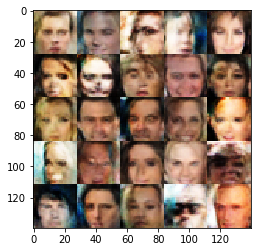

Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 1.9462
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.1623
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 2.3982
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 1.5312
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 1.8424
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 2.3109
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 2.7401
Epoch 1/1... Discriminator Loss: 0.7039... Generator Loss: 1.4043


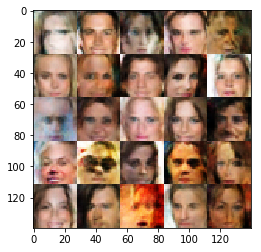

Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 1.7303
Epoch 1/1... Discriminator Loss: 0.3908... Generator Loss: 2.1255
Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 1.3510
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 2.0024
Epoch 1/1... Discriminator Loss: 0.3728... Generator Loss: 2.1100
Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 1.4868
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 1.9914
Epoch 1/1... Discriminator Loss: 0.5692... Generator Loss: 1.3663
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 2.5694


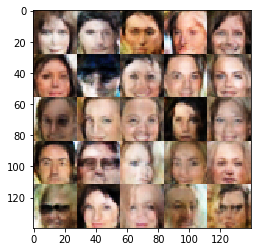

Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 2.3850
Epoch 1/1... Discriminator Loss: 0.3787... Generator Loss: 1.9839
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 1.6227
Epoch 1/1... Discriminator Loss: 0.4787... Generator Loss: 1.3170
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 1.6578
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 3.2395
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 2.1290


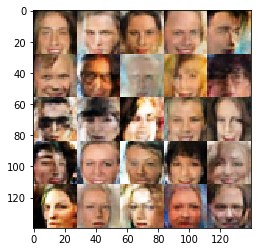

Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 2.6808
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 1.9321
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 1.8043
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 2.1090
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 2.6817
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 2.0157
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 2.3681
Epoch 1/1... Discriminator Loss: 0.3595... Generator Loss: 2.0227
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 2.4825


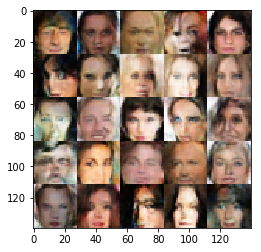

Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 1.6641
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 2.7863
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 1.8362
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 2.4009
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.6128
Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 1.7759
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 2.1655
Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 2.0549
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.1335


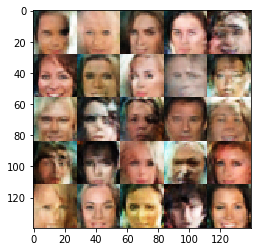

Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 2.6434
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 1.9711
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 1.9761
Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 2.5422
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 2.3436
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 2.2386
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 2.5384
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 1.8360
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 2.8045


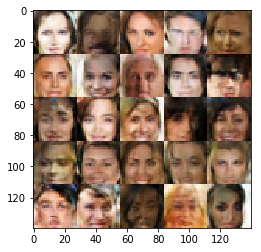

Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 2.0807
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 2.0511
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 1.8895
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 2.5752
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 3.2143
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 3.0443
Epoch 1/1... Discriminator Loss: 0.7223... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 1.9150
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 1.4331


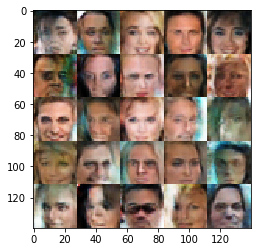

Epoch 1/1... Discriminator Loss: 0.2954... Generator Loss: 2.6516
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 3.3569
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 1.5547
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 1.7379
Epoch 1/1... Discriminator Loss: 0.3060... Generator Loss: 1.9397
Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 1.8034
Epoch 1/1... Discriminator Loss: 0.4159... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 1.8190


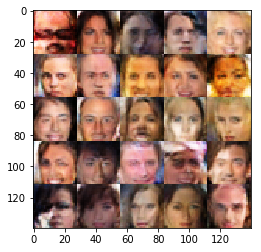

Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 1.5556
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 2.7485
Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 1.9924
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 2.0007
Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 2.2230
Epoch 1/1... Discriminator Loss: 0.3182... Generator Loss: 2.3574
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 1.5684
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 2.0349
Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 1.5312
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 1.9870


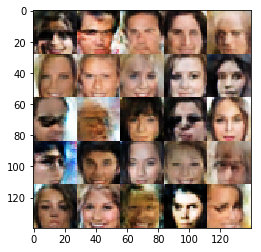

Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 3.0279
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 1.7578
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 1.7294
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 3.5612
Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 1.5159
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 2.1383
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 2.0070
Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 1.9284
Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 1.6476
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 2.6739


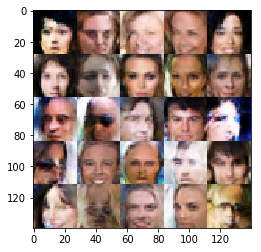

Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 3.1065
Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 2.2246
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 2.2086
Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 1.6282
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 2.3797
Epoch 1/1... Discriminator Loss: 0.3778... Generator Loss: 2.3436
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 1.9368
Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 2.6012
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 1.8418


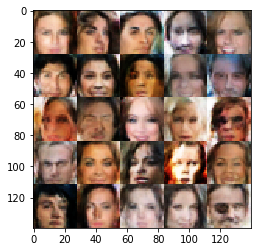

Epoch 1/1... Discriminator Loss: 0.3422... Generator Loss: 2.2797
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 1.9021
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.5303
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 2.4379
Epoch 1/1... Discriminator Loss: 0.3052... Generator Loss: 2.1919
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 1.8978
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 1.7786
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 2.8900
Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 2.2646
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 1.2950


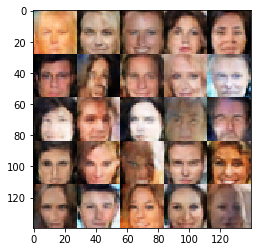

Epoch 1/1... Discriminator Loss: 0.3002... Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 0.3066... Generator Loss: 2.1582
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 2.2982


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.